In [131]:
# import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [132]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Data

First, we read in the data, dropping the index and the date.

In [133]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])
df=df[800:]

We identify the dependent and independent variables:

In [134]:
target = "Close"

In [135]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data processing for time series model

To process the data, we first define few terms

In [136]:
sequence_length = window = 20 # Number of time steps that will be inputted into LSTM network and Number of Predicting days 
torch.manual_seed(42)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [137]:
# close_min=min(df['Close'].values)
# close_max=max(df['Close'].values)
# df=(df-df.min())/(df.max()-df.min())

In [138]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [139]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
800,-0.664382,-0.518756,-0.212867,-0.376660,-2.096023,-0.541526,-0.618721,-0.664382,1.732245,-0.477768,...,2.765372,-0.923083,-0.285174,-0.957418,0.029832,-0.442130,-0.376660,-0.460099,0.479939,-0.664382
801,-0.646763,-0.405198,-0.255201,-0.392525,-1.648446,-0.526270,-0.600796,-0.646763,1.732245,-0.510207,...,2.765372,-0.947383,-0.387140,-1.015113,-0.059456,-0.471115,-0.392525,-0.463963,-0.746811,-0.646763
802,-0.651849,-0.315221,-0.292326,-0.409164,-1.448674,-0.518568,-0.605967,-0.651849,1.742954,-0.537690,...,2.671345,-0.935746,-0.466173,-1.005142,-0.147868,-0.500101,-0.409164,-0.467120,-0.835320,-0.651849
803,-0.695260,-0.219031,-0.333231,-0.428391,-1.458203,-0.511942,-0.650199,-0.695260,1.607479,-0.568214,...,2.671345,-0.959704,-0.550693,-1.010594,-0.236759,-0.531275,-0.428391,-0.473782,0.314693,-0.695260
804,-0.813687,-0.091393,-0.390878,-0.457822,-1.732959,-0.507468,-0.771680,-0.813687,1.580170,-0.615116,...,2.671345,-0.945671,-0.686218,-1.139791,-0.336992,-0.572362,-0.457822,-0.483073,-0.020605,-0.813687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.764009,-0.149978,0.687472,0.738442,0.156114,0.753486,0.755674,0.764009,1.389541,0.775099,...,-0.713624,1.462017,-0.279086,0.658465,-0.531071,0.759355,0.738442,0.919877,-1.255627,0.764009
3135,0.792344,-0.320354,0.718714,0.721971,0.421769,0.683547,0.781440,0.792344,1.353128,0.781322,...,-0.807650,1.459964,-0.237484,0.628980,-0.476021,0.779237,0.721971,0.918719,-1.228554,0.792344
3136,0.858642,-0.360917,0.725812,0.717688,0.821349,0.666530,0.841517,0.858642,1.392218,0.798688,...,-0.807650,1.463044,-0.160380,0.692283,-0.415414,0.804912,0.717688,0.916662,-0.521709,0.858642
3137,0.892608,-0.370429,0.727517,0.716729,1.019851,0.662588,0.872183,0.892608,1.391683,0.819186,...,-0.807650,1.479814,-0.076886,0.758568,-0.348987,0.834026,0.716729,0.915488,-0.821082,0.892608


The last step in the data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [140]:
def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

X_ts, y_ts = create_dataset(
    df,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_ts.shape, y_ts.shape)

torch.Size([460, 20, 24]) torch.Size([460, 20])


In [141]:
indices = tf.range(start=0, limit=tf.shape(X_ts)[0])
shuffled_indices = tf.random.shuffle(indices)

In [142]:
X_ts = tf.gather(X_ts, shuffled_indices)
y_ts = tf.gather(y_ts, shuffled_indices)
print(X_ts.shape, y_ts.shape)
X_ts=torch.FloatTensor(np.array(X_ts))
y_ts=torch.FloatTensor(np.array(y_ts))
print(X_ts.shape, y_ts.shape)

(460, 20, 24) (460, 20)
torch.Size([460, 20, 24]) torch.Size([460, 20])


In [143]:
# Train test split
n=X_ts.shape[0] # get first dimension
size=int(n*0.9)
X_train_ts=X_ts[:size]
y_train_ts=y_ts[:size]
X_test_ts=X_ts[size:]
y_test_ts=y_ts[size:]
print('Shape of train is',X_train_ts.shape,'and',y_train_ts.shape)
print('Shape os test is',X_test_ts.shape,'and',y_test_ts.shape)

Shape of train is torch.Size([414, 20, 24]) and torch.Size([414, 20])
Shape os test is torch.Size([46, 20, 24]) and torch.Size([46, 20])


In [144]:
train_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=True, batch_size=batch_size)

In [145]:
# The unknown data
X_check=(df[features].values)[len(df)-window-sequence_length:len(df)- window]
y_check=(df[target].values)[len(df)-window:len(df)]
torch.FloatTensor([X_check]).shape

torch.Size([1, 20, 24])

In [146]:
X_check

array([[ 1.05844214, -0.19716968,  0.75959957,  0.80516313,  1.21592729,
         0.81014498,  1.0208129 ,  1.05844214,  0.79302159,  0.8132752 ,
         0.85160002,  1.05832725, -0.80714765, -0.40596154,  0.00628931,
        -0.33751597,  1.66531029, -0.46132203,  1.0267621 , -0.85619257,
         0.69737467,  0.80516313,  1.07490531,  0.33719206],
       [ 1.16360979, -0.07160229,  0.73748563,  0.81858003,  1.46921145,
         0.86331144,  1.11414635,  1.16360979,  0.80266014,  0.88129793,
         0.88581386,  1.06690863, -0.81716517, -0.42146188, -0.01617262,
        -0.43154287,  1.63382382, -0.19384604,  1.47645234, -0.7267417 ,
         0.7646153 ,  0.81858003,  1.07164371, -0.57175877],
       [ 1.19557785,  0.06292609,  0.71762843,  0.83736927,  1.37200998,
         0.92509087,  1.14237711,  1.19557785,  0.87923305,  0.94287189,
         0.91992414,  1.07651383, -0.82718633, -0.43698916, -0.03872802,
        -0.43154287,  1.62013404,  0.03791227,  1.74878423, -0.57338238,
  

In [147]:
y_check

array([0.63831643, 0.55349209, 0.46666974, 0.45831446, 0.48192723,
       0.57220067, 0.59599508, 0.60507692, 0.60507692, 0.83466572,
       0.85046811, 0.78762181, 0.83375753, 0.81250604, 0.78544217,
       0.76400904, 0.79234436, 0.85864176, 0.89260783, 0.89260783])

In [148]:
# for X, y in train_loader:
#     print(X)
#     print(y)

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [149]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Running the Classical LSTM

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. 

In [150]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(out_)
        return torch.squeeze(out)

In [151]:
learning_rate = 0.005
num_hidden_units = 200

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [152]:
lstm_loss_train = []
lstm_loss_test=[]
num_epoch=300
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model_lstm, loss_function)
    lstm_loss_train.append(train_loss)
    lstm_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.4496972457720683
Test loss: 0.19544229408105215
Epoch 1
---------
Train loss: 0.22099773241923407
Test loss: 0.14726712803045908
Epoch 2
---------
Train loss: 0.1736802667952501
Test loss: 0.17414199809233347
Epoch 3
---------
Train loss: 0.19416369612400347
Test loss: 0.1582543154557546
Epoch 4
---------
Train loss: 0.16735263655965144
Test loss: 0.16677281260490417
Epoch 5
---------
Train loss: 0.20095356783041587
Test loss: 0.17635056376457214
Epoch 6
---------
Train loss: 0.12065774374283277
Test loss: 0.12746815383434296
Epoch 7
---------
Train loss: 0.10495911968442109
Test loss: 0.11627281208833058
Epoch 8
---------
Train loss: 0.11114163524829425
Test loss: 0.10592952122290929
Epoch 9
---------
Train loss: 0.10176738910377026
Test loss: 0.1416852648059527
Epoch 10
---------
Train loss: 0.17345168556158358
Test loss: 0.14693274845679602
Epoch 11
---------
Train loss: 0.1236700345403873
Test loss: 0.15274840344985327
Epoch 12
---------
Train loss: 

Train loss: 0.004298964631743729
Test loss: 0.01412691796819369
Epoch 100
---------
Train loss: 0.005887452127913443
Test loss: 0.013713647611439228
Epoch 101
---------
Train loss: 0.0067561485876257606
Test loss: 0.012884016148746014
Epoch 102
---------
Train loss: 0.010505813926171798
Test loss: 0.01629514495531718
Epoch 103
---------
Train loss: 0.007626813514014849
Test loss: 0.01403139935185512
Epoch 104
---------
Train loss: 0.0055578043057511635
Test loss: 0.012324548636873564
Epoch 105
---------
Train loss: 0.004242341893796737
Test loss: 0.013916187919676304
Epoch 106
---------
Train loss: 0.004528084698204811
Test loss: 0.011810159931580225
Epoch 107
---------
Train loss: 0.006022722827485547
Test loss: 0.015789459149042766
Epoch 108
---------
Train loss: 0.008773445581587462
Test loss: 0.019199372579654057
Epoch 109
---------
Train loss: 0.0101687465257083
Test loss: 0.020035235211253166
Epoch 110
---------
Train loss: 0.00896406865033966
Test loss: 0.01778939242164294
Epoch

Train loss: 0.004265482268797664
Test loss: 0.0170901936168472
Epoch 197
---------
Train loss: 0.004287706768641679
Test loss: 0.01961722287038962
Epoch 198
---------
Train loss: 0.004242585667480643
Test loss: 0.018314178412159283
Epoch 199
---------
Train loss: 0.0042330521212604185
Test loss: 0.017807462563117344
Epoch 200
---------
Train loss: 0.00433891975822357
Test loss: 0.01809943498422702
Epoch 201
---------
Train loss: 0.004213196682170606
Test loss: 0.01802413972715537
Epoch 202
---------
Train loss: 0.003593879805591244
Test loss: 0.017269207475086052
Epoch 203
---------
Train loss: 0.0032723307108076718
Test loss: 0.018975948294003803
Epoch 204
---------
Train loss: 0.003052744159224228
Test loss: 0.01844898611307144
Epoch 205
---------
Train loss: 0.0029052715712728407
Test loss: 0.01825155783444643
Epoch 206
---------
Train loss: 0.002699111686804547
Test loss: 0.017020600227018196
Epoch 207
---------
Train loss: 0.0026264006558519145
Test loss: 0.018836496397852898
Epoc

Train loss: 0.010872054934644928
Test loss: 0.022845981021722157
Epoch 293
---------
Train loss: 0.027843189783967458
Test loss: 0.055533718317747116
Epoch 294
---------
Train loss: 0.04150060628755735
Test loss: 0.09442576269308726
Epoch 295
---------
Train loss: 0.05336704198271036
Test loss: 0.04135033239920934
Epoch 296
---------
Train loss: 0.03085402907946935
Test loss: 0.03253349599738916
Epoch 297
---------
Train loss: 0.01958476107280988
Test loss: 0.02734166383743286
Epoch 298
---------
Train loss: 0.013557004652774105
Test loss: 0.0238126286615928
Epoch 299
---------
Train loss: 0.010146014141635252
Test loss: 0.020493340368072193


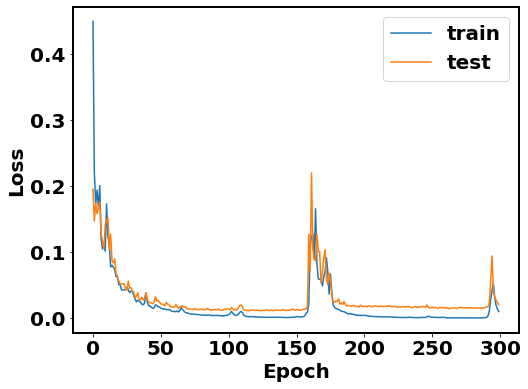

In [153]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [154]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [155]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, model_lstm)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [156]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [157]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)
mae_test_lstm, rmse_test_lstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_lstm)
print('RMSE test error is',rmse_test_lstm)

MAE train error is 31.911029668954704
RMSE train error is 46.39047167851375
MAE test error is 54.081929524739586
RMSE test error is 78.49486287434895


In [158]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  37.168847656249866
RMSE check error :  51.04350220946219


## Running the ARIMA 

In [159]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

<ipython-input-159-c2c42f0d7345>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [160]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
train_data_arima=df[target].values[:len(df)-window] # train on full data
check_data_arima=df[target].values[len(df)-window:]

<ipython-input-160-de4a1ff72067>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [161]:
print(check_data_arima)

[0.63831643 0.55349209 0.46666974 0.45831446 0.48192723 0.57220067
 0.59599508 0.60507692 0.60507692 0.83466572 0.85046811 0.78762181
 0.83375753 0.81250604 0.78544217 0.76400904 0.79234436 0.85864176
 0.89260783 0.89260783]


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3191.090, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3189.094, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3189.094, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3193.036, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3187.110, Time=0.28 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.983 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2319
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1597.518
Date:                Tue, 06 Feb 2024   AIC                          -3193.036
Time:                        19:54:55   BIC                          -3187.288
Sample:                             0   HQIC                         -3190.941
                               - 2319                                  

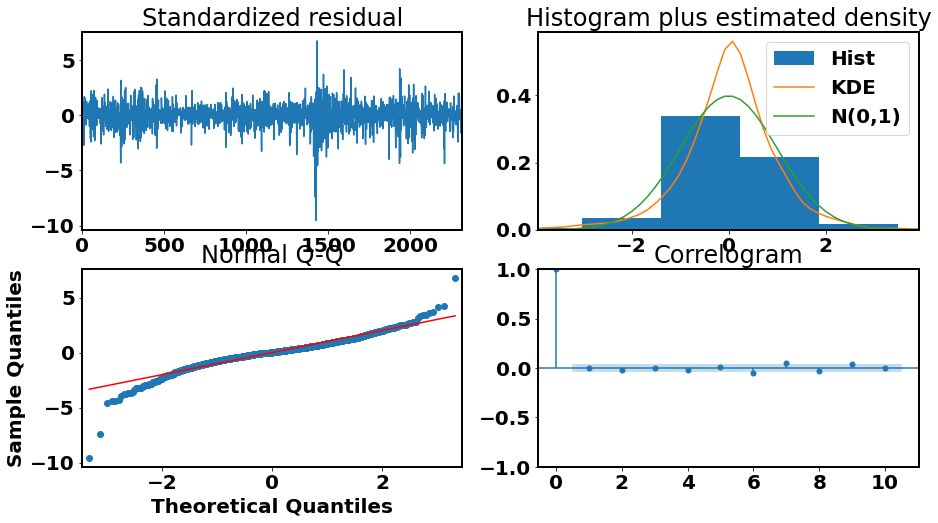

In [162]:
model_autoARIMA = auto_arima(train_data_arima, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [163]:
import statsmodels.api as sm
model = ARIMA(train_data_arima, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2319
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1603.769
Date:                Tue, 06 Feb 2024   AIC                          -3197.537
Time:                        19:54:56   BIC                          -3168.793
Sample:                             0   HQIC                         -3187.062
                               - 2319                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0055      0.388     -0.014      0.989      -0.767       0.756
ar.L1          0.1371      0.074      1.860      0.063      -0.007       0.281
ar.L2          0.8496      0.073     11.601      0.0

In [164]:
# Forecast
y_check_pred_arima = fitted.forecast(window, alpha=0.05)  # 95% conf

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [165]:
mae_check_arima = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean)
print('Mean absolute error(check) : ',mae_check_arima)
rmse_check_arima = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean, squared=False)
print('Root Mean Squared error(check) : ',rmse_check_arima)

Mean absolute error(check) :  90.87650008588835
Root Mean Squared error(check) :  99.47111107921847


## Data processing for regression model

In [166]:
# Data for regression model
sequence_length_reg = window_reg =20 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,5):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(460, 20, 24) (460, 20)


In [167]:
indices = tf.range(start=0, limit=tf.shape(X_reg)[0])
shuffled_indices = tf.random.shuffle(indices)

In [168]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [169]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (414, 20, 24) and (414, 20)
Shape os test is (46, 20, 24) and (46, 20)


In [170]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(8280, 24)
(8280,)


In [171]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(920, 24)
(920,)


In [172]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg:len(df)- window_reg]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

## Linear regression model

In [173]:
from sklearn.linear_model import LinearRegression
#Creating the Regressor
regressor = LinearRegression()
regressor.fit(X_train_reg_, y_train_reg_)

LinearRegression()

In [174]:
y_train_pred_mlr=regressor.predict(X_train_reg_)
mae_train_mlr = mean_absolute_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean)
print('MAE train Error : ',mae_train_mlr)
rmse_train_mlr = mean_squared_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE train Error : ',rmse_train_mlr)

MAE train Error :  158.1852716369906
RMSE train Error :  223.31064155822045


In [175]:
y_test_pred_mlr=regressor.predict(X_test_reg_)
mae_test_mlr = mean_absolute_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean)
print('MAE test Error : ',mae_test_mlr)
rmse_test_mlr = mean_squared_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE test Error : ',rmse_test_mlr)

MAE test Error :  174.03465371032092
RMSE test Error :  220.43268960528277


In [176]:
y_check_pred_mlr = regressor.predict(X_check_reg)
mae_check_mlr = mean_absolute_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean)
print('MAE check error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE check error: ',rmse_check_mlr)

MAE check error :  409.9153437249426
RMSE check error:  450.0716668094045


## XGboost

In [177]:
import xgboost as xg

In [178]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                   seed = 123) 
# Fitting the model 
xgb_r.fit(X_train_reg_, y_train_reg_) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [179]:
# Predict the model 
y_train_pred_xg = xgb_r.predict(X_train_reg_) 
mae_train_xg = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean)
print('MAE train: ',mae_train_xg)
rmse_train_xg = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_xg)

MAE train:  10.03892788062349
RMSE train:  13.107343402584945


In [180]:
# Predict the model 
y_test_pred_xg = xgb_r.predict(X_test_reg_) 
mae_test_xg = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean)
print('MAE test: ',mae_test_xg)
rmse_test_xg = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE test: ',rmse_test_xg)

MAE test:  11.317232719089668
RMSE test:  14.967179393751316


In [181]:
# Predict the model 
y_check_pred_xg = xgb_r.predict(X_check_reg) 
mae_check_xg = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  114.364169921875
Root Mean Squared Error :  283.3357663656535


## ANN

In [182]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model

In [183]:
input_ = Input((len(features),)) # feature

den1=Dense(256, use_bias=True,activation='relu')(input_)

den2=Dense(128, use_bias=True,activation='relu')(den1)

den3=Dense(64, use_bias=True,activation='relu')(den2)

den4=Dense(32, use_bias=True,activation='relu')(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model = Model(inputs=[input_], outputs=den5)

In [184]:
import tensorflow as tf

In [185]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(opt, loss=loss_fn)

In [186]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=32, 
                   epochs=300,  # total epoch
                   )

Epoch 1/300
259/259 [==============================] - 1s 2ms/step - loss: 0.1343 - val_loss: 0.0902
Epoch 2/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0616 - val_loss: 0.0772
Epoch 3/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0447 - val_loss: 0.0485
Epoch 4/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0334 - val_loss: 0.0393
Epoch 5/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0254 - val_loss: 0.0258
Epoch 6/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0247 - val_loss: 0.0261
Epoch 7/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0210 - val_loss: 0.0169
Epoch 8/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0208 - val_loss: 0.0274
Epoch 9/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0175 - val_loss: 0.0166
Epoch 10/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0164 - val_lo

259/259 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 82/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 83/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 84/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 85/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0041
Epoch 86/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0049
Epoch 87/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 88/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0033
Epoch 89/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 90/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 

Epoch 161/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 162/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 163/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 164/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 165/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 166/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 167/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 168/300
259/259 [==============================] - 1s 2ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 169/300
259/259 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 170/300
259/259 [==============================] - 0s 1ms/step - lo

259/259 [==============================] - 0s 1ms/step - loss: 7.3620e-04 - val_loss: 0.0017
Epoch 240/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 241/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0013 - val_loss: 8.5685e-04
Epoch 242/300
259/259 [==============================] - 0s 1ms/step - loss: 8.5261e-04 - val_loss: 0.0010
Epoch 243/300
259/259 [==============================] - 0s 1ms/step - loss: 8.9967e-04 - val_loss: 0.0011
Epoch 244/300
259/259 [==============================] - 0s 1ms/step - loss: 9.0466e-04 - val_loss: 0.0022
Epoch 245/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 246/300
259/259 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 247/300
259/259 [==============================] - 0s 1ms/step - loss: 7.6591e-04 - val_loss: 8.7968e-04
Epoch 248/300
259/259 [==============================] - 0s

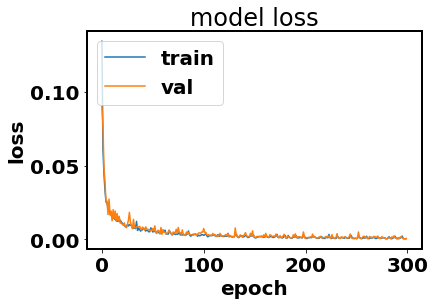

In [187]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [188]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

MAE train:  8.802349883001208
RMSE train:  12.238148212324887


In [189]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test : ',rmse_test_ann)

MAE test:  10.036076129415763
RMSE test :  13.640934718393263


In [190]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_5 (Dense)             (None, 256)               6400      
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable

In [191]:
y_check_pred_nn = model.predict(X_check_reg)
y_check_pred_nn=y_check_pred_nn.flatten()
mae_check_nn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  26.63265136718751
Root Mean Squared Error :  64.64910412815617


In [192]:
mape_check_nn = mean_absolute_percentage_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean)
print('MAPE percentage: ',mape_check_nn*100)

MAPE percentage:  0.35611834092131184


In [193]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_train_lstm,mae_test_lstm, rmse_train_lstm,rmse_test_lstm], 
    ["Multiple linear regression",mae_train_mlr,mae_test_mlr, rmse_train_mlr,rmse_test_mlr], 
      ["XGboost", mae_train_xg, mae_test_xg, rmse_train_xg,rmse_test_xg],
    ["ANN", mae_train_ann, mae_test_ann,  rmse_train_ann ,rmse_test_ann]
]
 
# create header
head = ["Model","Train MAE" ,"Test MAE", "Train RMSE","Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+------------+--------------+-------------+
| Model                      |   Train MAE |   Test MAE |   Train RMSE |   Test RMSE |
+============================+=============+============+==============+=============+
| LSTM                       |    31.911   |    54.0819 |      46.3905 |     78.4949 |
+----------------------------+-------------+------------+--------------+-------------+
| Multiple linear regression |   158.185   |   174.035  |     223.311  |    220.433  |
+----------------------------+-------------+------------+--------------+-------------+
| XGboost                    |    10.0389  |    11.3172 |      13.1073 |     14.9672 |
+----------------------------+-------------+------------+--------------+-------------+
| ANN                        |     8.80235 |    10.0361 |      12.2381 |     13.6409 |
+----------------------------+-------------+------------+--------------+-------------+


## Comparison

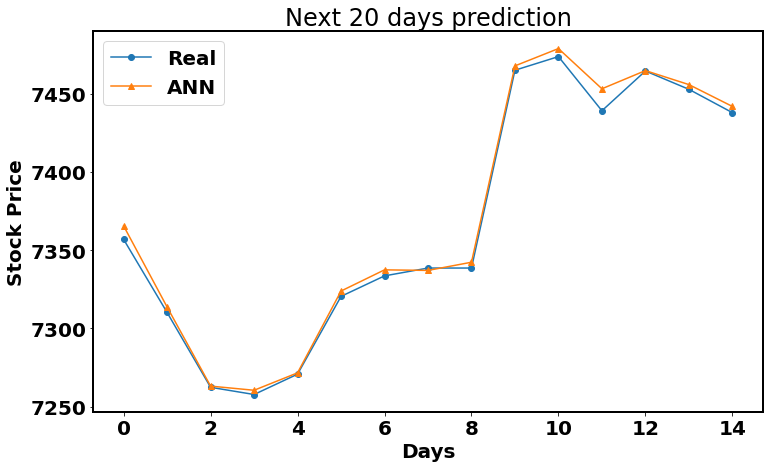

In [194]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_reg[:window-5]* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_nn[:window-5]* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

In [213]:
y_check_reg

array([0.63831643, 0.55349209, 0.46666974, 0.45831446, 0.48192723,
       0.57220067, 0.59599508, 0.60507692, 0.60507692, 0.83466572,
       0.85046811, 0.78762181, 0.83375753, 0.81250604, 0.78544217,
       0.76400904, 0.79234436, 0.85864176, 0.89260783, 0.89260783])

In [215]:
y_check

array([0.63831643, 0.55349209, 0.46666974, 0.45831446, 0.48192723,
       0.57220067, 0.59599508, 0.60507692, 0.60507692, 0.83466572,
       0.85046811, 0.78762181, 0.83375753, 0.81250604, 0.78544217,
       0.76400904, 0.79234436, 0.85864176, 0.89260783, 0.89260783])

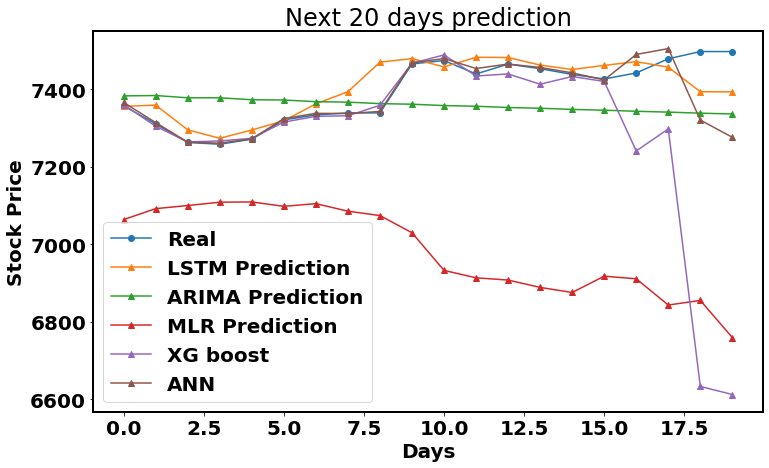

In [195]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
plt.plot(y_check_pred_mlr* target_stdev + target_mean, label = "MLR Prediction",marker='^')
plt.plot(y_check_pred_xg* target_stdev + target_mean, label = "XG boost",marker='^')
plt.plot(y_check_pred_nn* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

In [196]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Check MAE" , "Check RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+--------------+
| Model                      |   Check MAE |   Check RMSE |
+============================+=============+==============+
| LSTM                       |     37.1688 |      51.0435 |
+----------------------------+-------------+--------------+
| ARIMA                      |     90.8765 |      99.4711 |
+----------------------------+-------------+--------------+
| Multiple linear regression |    174.035  |     450.072  |
+----------------------------+-------------+--------------+
| XGboost                    |    114.364  |     283.336  |
+----------------------------+-------------+--------------+
| ANN                        |     26.6327 |      64.6491 |
+----------------------------+-------------+--------------+


In [197]:
low_=0
high_=window-5

In [198]:
list_real=list(y_check* target_stdev + target_mean)[low_:high_]
list_real_=list(y_check_reg* target_stdev + target_mean)[low_:high_]
list_lstm=list(y_check_pred_lstm* target_stdev + target_mean)[low_:high_]
list_arima=list(y_check_pred_arima* target_stdev + target_mean)[low_:high_]
list_mlr=list(y_check_pred_mlr* target_stdev + target_mean)[low_:high_]
list_xg=list(y_check_pred_xg* target_stdev + target_mean)[low_:high_]
list_nn=list(y_check_pred_nn* target_stdev + target_mean)[low_:high_]

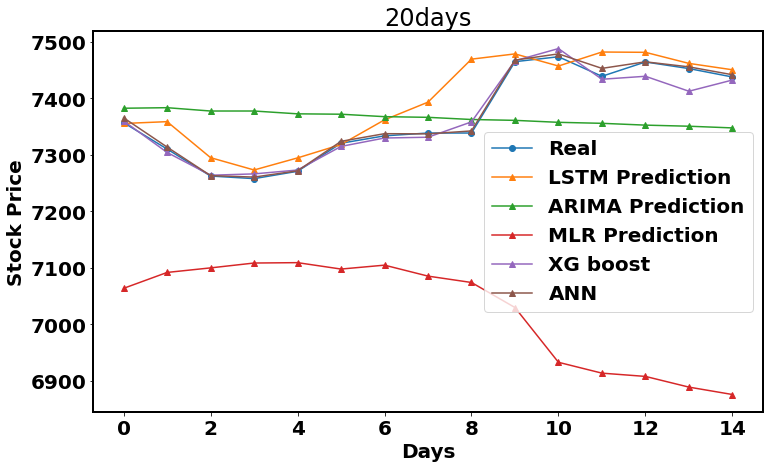

In [199]:
plt.figure(figsize=(12, 7))
plt.plot(list_real_, label = "Real",marker='o')
# plt.plot(list_real, label = "Real",marker='o')
plt.plot(list_lstm, label = "LSTM Prediction",marker='^')
plt.plot(list_arima, label = "ARIMA Prediction",marker='^')
plt.plot(list_mlr, label = "MLR Prediction",marker='^')
plt.plot(list_xg, label = "XG boost",marker='^')
plt.plot(list_nn, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window)+'days')
plt.legend()
plt.show()

In [200]:
save_data=[list_real,list_lstm,
          list_arima,list_mlr,
          list_xg,list_nn]

In [201]:
import csv 
# name of csv file   
filename = "Stock Prediction_predict_3_ver_2_DRC.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)

In [202]:
mae_check_lstm = mean_absolute_error(list_real,list_lstm)
print('Mean absolute Error : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(list_real,list_lstm, squared=False)
print('Root Mean Squared Error : ',rmse_check_lstm)

Mean absolute Error :  29.986601562499892
Root Mean Squared Error :  43.196315794321606


In [203]:
mae_check_arima = mean_absolute_error(list_real,list_arima)
print('Mean absolute Error : ',mae_check_arima)
rmse_check_arima = mean_squared_error(list_real,list_arima, squared=False)
print('Root Mean Squared Error : ',rmse_check_arima)

Mean absolute Error :  78.70202461148887
Root Mean Squared Error :  86.21314853816355


In [204]:
mae_check_mlr = mean_absolute_error(list_real,list_mlr)
print('Mean absolute Error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(list_real,list_mlr, squared=False)
print('Root Mean Squared Error : ',rmse_check_mlr)

Mean absolute Error :  342.8878235144277
Root Mean Squared Error :  378.6093111997719


In [205]:
mae_check_xg = mean_absolute_error(list_real,list_xg)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(list_real, list_xg, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  10.010872395833394
Root Mean Squared Error :  14.468843206227666


In [206]:
mae_check_nn = mean_absolute_error(list_real,list_nn)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(list_real, list_nn, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  3.871074218750012
Root Mean Squared Error :  5.122378233974536


In [207]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Test MAE" , "Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+------------+-------------+
| Model                      |   Test MAE |   Test RMSE |
+============================+============+=============+
| LSTM                       |   29.9866  |    43.1963  |
+----------------------------+------------+-------------+
| ARIMA                      |   78.702   |    86.2131  |
+----------------------------+------------+-------------+
| Multiple linear regression |  174.035   |   378.609   |
+----------------------------+------------+-------------+
| XGboost                    |   10.0109  |    14.4688  |
+----------------------------+------------+-------------+
| ANN                        |    3.87107 |     5.12238 |
+----------------------------+------------+-------------+


In [208]:
df_=pd.read_csv('Stock Prediction_predict_3_ver_2_DRC.csv',header=None)  

In [209]:
result_real=df_.iloc[0,:].values
result_lstm=df_.iloc[1,:].values
result_arima=df_.iloc[2,:].values
result_mlr=df_.iloc[3,:].values
result_xg=df_.iloc[4,:].values
result_nn=df_.iloc[5,:].values

In [210]:
from sklearn.metrics import r2_score
print ('R2 score between real and lstm',r2_score(result_real, result_lstm))
print ('R2 score between real and ARIMA',r2_score(result_real, result_arima))
print ('R2 score between real and MLR',r2_score(result_real, result_mlr))
print ('R2 score between real and xg',r2_score(result_real, result_xg))
print ('R2 score between real and nn',r2_score(result_real, result_nn))

R2 score between real and lstm 0.6833884144466067
R2 score between real and ARIMA -0.26118830185758757
R2 score between real and MLR -23.322908312135894
R2 score between real and xg 0.964477674830587
R2 score between real and nn 0.9955478980397966


In [211]:
def accuracy(y_true, y_pred, threshold):
    c=0
    for i in range(len(y_true)):
        if abs(y_true[i]-y_pred[i])<threshold:
            c=c+1
    return c/len(y_true)

In [212]:
threshold=100
print('The mean absolute error between real and lstm is',accuracy(result_real, result_lstm,threshold))
print('The mean absolute error between real and arima is',accuracy(result_real, result_arima,threshold))
print('The mean absolute error between real and MLR is',accuracy(result_real, result_mlr,threshold))
print('The mean absolute error between real and xg is',accuracy(result_real, result_xg,threshold))
print('The mean absolute error between real and nn is',accuracy(result_real, result_nn,threshold))

The mean absolute error between real and lstm is 0.9333333333333333
The mean absolute error between real and arima is 0.5333333333333333
The mean absolute error between real and MLR is 0.0
The mean absolute error between real and xg is 1.0
The mean absolute error between real and nn is 1.0
